In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import cv2
import os
import matplotlib.pyplot as plt

from imutils import paths
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.models import load_model

C:\Users\DinosaurMom\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 訓練模型

In [2]:
imagePaths_train = sorted(list(paths.list_images(".\\Dataset\\OK\\train")))
imagePaths_test = sorted(list(paths.list_images(".\\Dataset\\OK\\test")))

#IMAGE_DIMS = (32, 32, 3)
train_feature = []
train_label = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
test_feature = []
test_label = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [3]:
for imagePath in imagePaths_train:
    #print(imagePath)
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath, 0)
    image = img_to_array(image)
    train_feature.append(image)
for imagePath in imagePaths_test:
    #print(imagePath)
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath, 0)
    image = img_to_array(image)
    test_feature.append(image)

In [4]:
train_feature = np.array(train_feature, dtype="float")
test_feature = np.array(test_feature, dtype="float")
train_label = np.array(train_label)
test_label = np.array(test_label)

print("Train Data shape:" + str(train_feature.shape))
print("Test Data shape:" + str(test_feature.shape))
print("Train Label shape:" + str(train_label.shape))
print("Test Label shape:" + str(test_label.shape))

Train Data shape:(40, 32, 32, 1)
Test Data shape:(20, 32, 32, 1)
Train Label shape:(40,)
Test Label shape:(20,)


In [5]:
def show_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='gray')
    plt.show() 

def show_images_labels_predictions(images,labels,
                                  predictions,start_id,num=10):
    plt.gcf().set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        #顯示黑白圖片
        ax.imshow(images[start_id], cmap='gray')
        
        # 有 AI 預測結果資料, 才在標題顯示預測結果
        if( len(predictions) > 0 ) :
            title = 'ai = ' + str(predictions[start_id])
            # 預測正確顯示(o), 錯誤顯示(x)
            title += (' (o)' if predictions[start_id]==labels[start_id] else ' (x)') 
            title += '\nlabel = ' + str(labels[start_id])
        # 沒有 AI 預測結果資料, 只在標題顯示真實數值
        else :
            title = 'label = ' + str(labels[start_id])
            
        # X, Y 軸不顯示刻度    
        ax.set_title(title,fontsize=12) 
        ax.set_xticks([]);ax.set_yticks([])        
        start_id+=1 
    plt.show()

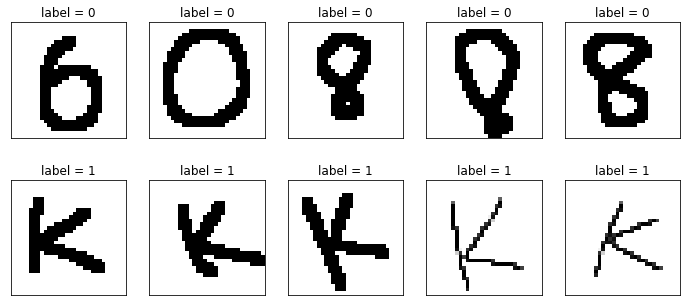

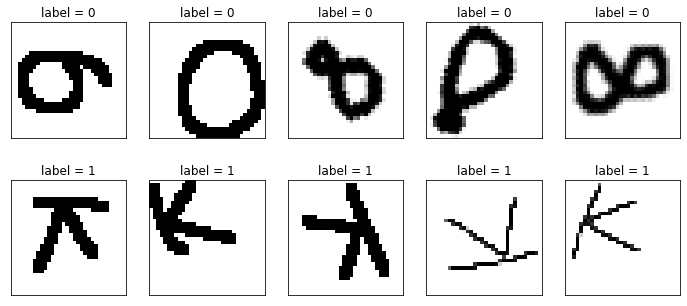

In [6]:
#原始測試圖片
show_images_labels_predictions(test_feature,test_label,[],0,10)
#經位移、旋轉之測試圖片
show_images_labels_predictions(test_feature,test_label,[],10,10)

In [7]:
#Features 特徵值標準化
train_feature_normalize = train_feature/255
test_feature_normalize = test_feature/255
#print(train_feature_normalize)

In [8]:
#label 轉換為 One-Hot Encoding 編碼
train_label_onehot = to_categorical(train_label)
test_label_onehot = to_categorical(test_label)
print(test_label_onehot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## 可更改參數：
### 1.卷積層：kernel_size, padding
### 2.池化層：MaxPool2D為最大池化；AvgPool2D為均值池化, pool_size
### 3.隱藏層：node數量

In [9]:
# 建立一個線性堆疊的模型
model = Sequential()

# 建立卷積層
# filters：濾鏡的層數
# kernel_size(a,b)：濾鏡的大小為axb
# padding='same'：使影像經過卷積計算後大小不變
# input_shape(a,b,c)：a,b為輸入影像的大小，c為單色或彩色
# activation：設定激勵函數
model.add(Conv2D(filters=8, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(32, 32, 1)))

# 建立池化層
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# 平坦層
model.add(Flatten())

#FCN
#建立隱藏層
model.add(Dense(units=512 , activation='relu'))
# Fully connected的layer，因為輸出要是O或K，所以最後一個layer的輸出一定要是2維，所以unit就設2
# Activation function我們通常會用softmax，使用softmax意味著輸出的每一個維度的值都會介於0~1之間且總和是1，就可以當作是機率來看待
model.add(Dense(units = 2 , activation='softmax'))

model.summary()

# 卷積層 Param =（卷積核長度 *卷積核寬度 *通道數 +1）*卷積核個數
# 全連接層 Param = （輸入數據維度+1）* 神經元個數
# 加1是考慮到每個神經元都有一個 Bias

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 8)           584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 8)          0

In [10]:
# 定義訓練方式:設定損失函數，最佳化方法，以及評估模型
model.compile(loss='categorical_crossentropy', \
              optimizer='adam',                 \
              metrics=['accuracy'])

In [11]:
#以(train_feature_normalize,train_label_onehot)資料訓練，
#訓練資料保留 20% 作驗證,訓練20次、每批次讀取4筆資料，顯示簡易訓練過程
train_history =model.fit(x=train_feature_normalize,
                         y=train_label_onehot,validation_split=0.2, 
                         epochs=20, batch_size=4,verbose=2)

Epoch 1/20
8/8 - 1s - loss: 0.6707 - accuracy: 0.5625 - val_loss: 1.0898 - val_accuracy: 0.0000e+00 - 966ms/epoch - 121ms/step
Epoch 2/20
8/8 - 0s - loss: 0.6482 - accuracy: 0.6250 - val_loss: 1.1456 - val_accuracy: 0.0000e+00 - 69ms/epoch - 9ms/step
Epoch 3/20
8/8 - 0s - loss: 0.5597 - accuracy: 0.7500 - val_loss: 0.6151 - val_accuracy: 0.8750 - 68ms/epoch - 8ms/step
Epoch 4/20
8/8 - 0s - loss: 0.5002 - accuracy: 0.9062 - val_loss: 0.5851 - val_accuracy: 0.7500 - 64ms/epoch - 8ms/step
Epoch 5/20
8/8 - 0s - loss: 0.3880 - accuracy: 0.7812 - val_loss: 0.6832 - val_accuracy: 0.5000 - 68ms/epoch - 8ms/step
Epoch 6/20
8/8 - 0s - loss: 0.3088 - accuracy: 0.9062 - val_loss: 0.4139 - val_accuracy: 0.8750 - 63ms/epoch - 8ms/step
Epoch 7/20
8/8 - 0s - loss: 0.2389 - accuracy: 0.9062 - val_loss: 0.4668 - val_accuracy: 0.7500 - 74ms/epoch - 9ms/step
Epoch 8/20
8/8 - 0s - loss: 0.1888 - accuracy: 0.9375 - val_loss: 0.1997 - val_accuracy: 0.8750 - 69ms/epoch - 9ms/step
Epoch 9/20
8/8 - 0s - loss: 0

In [12]:
#評估準確率
scores = model.evaluate(test_feature_normalize, test_label_onehot)
print('\n準確率=',scores[1])

1/1 [==============================] - 0s 199ms/step - loss: 0.7573 - accuracy: 0.8000

準確率= 0.800000011920929


In [13]:
#將模型儲存至 HDF5檔案中
model.save('OK_CNN_model.h5')

### 測試模型

In [14]:
predict=model.predict(test_feature_normalize)
prediction=np.argmax(predict,axis=1)

In [15]:
# 顯示圖片及預測結果的函數
import random

def plot_images_labels_prediction(images, labels, prediction=[], names=[], predictions_array=[], num=20):
    # 取得 pyplot 物件參考
    fig = plt.gcf()

    # 設定畫布大小為 12 吋*14吋
    fig.set_size_inches(12, 14)

    idx = random.randint(0, images.shape[0] - 1)

    # 限制最多顯示 20 個子圖
    if num > 20: num = 20

    # 依序顯示 num 個子圖
    for i in range(0, num):
        # 建立 5*5 個子圖中的第 i+1 個 
        ax = plt.subplot(5, 5, i + 1)

        # 顯示子圖
        ax.imshow(images[idx], cmap='gray')

        title = ""
        color = 'black'
        label = labels[idx]
        pred = None

        # 有預測值就加入標題中
        if len(prediction) > 0:
            if prediction[idx] != labels[idx]:
                color = 'red'
                confidence = 100 * np.min(predictions_array[idx])
            else:
                color = 'blue'
                confidence = 100 * np.max(predictions_array[idx])
            pred = prediction[idx]
        
        if len(names) > 0:
            # print(names)
            # print(label)
            label = names[label]
            if pred != None:
                pred = names[pred]

        title = "label = " + str(label)
        if pred != None: title += "\npredict = " + str(pred)

        title = "{}\nscore={:2.2f}%".format(title, confidence)

        # 設定標題
        ax.set_title(title, fontsize=10, color=color) 
        
        # 不顯示 x 、y軸刻度
        ax.set_xticks([]);  
        ax.set_yticks([]);
        
        # 樣本序號增量 1
        idx += 1    
        if idx >= images.shape[0]:
            idx = 0
    
    # 繪製圖形
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
    plt.show()

In [16]:
print(test_feature.shape)
print(np.argmax(test_label_onehot, axis=1))
print(np.argmax(predict, axis=1))

(20, 32, 32, 1)
[0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1]
[0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1]


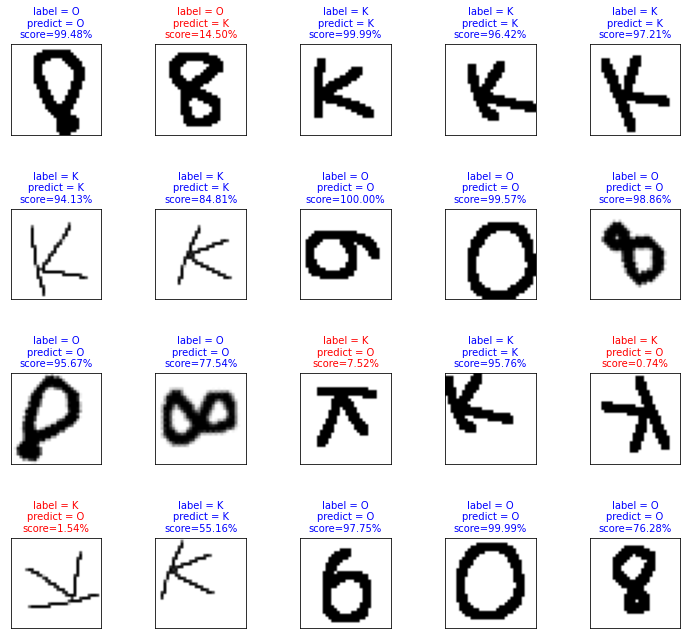

In [17]:
NAMES = ['O', 'K']
plot_images_labels_prediction(test_feature, np.argmax(test_label_onehot, axis=1), np.argmax(predict, axis=1), NAMES, predictions_array=predict)